# Lorenz-System

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn-whitegrid")
plt.rcParams["font.size"] = 12

In [2]:
class LorenzSystem:
    
    def __init__(self, rho, r, b):
        '''initialize the object with the parameters rho, r and b of the system'''
        
        self.rho = rho
        self.r = r
        self.b = b
                
    def ODE(self, state):
        '''differential equation of the object: x'=rho*(x-y), y'=x*(r-z)-y, z'=x*y-b*z'''
        
        x, y, z = state
        return np.array([self.rho*(x-y), x*(self.r-z)-y, x*y-self.b*z])
    
    def solve(self, state0, t, steps=4):
        '''solves the ODE with given initial state and discretized time interval using ABE'''
        
        state0 = np.array(state0)
        steps = steps if 0 < steps < 5 else 4
        N = len(t)-1
        h = (t[-1] - t[0]) / N
        
        # initialize state array with initial state
        states = np.zeros((N+1, 3))
        states[0] = state0
        
        # initialize ODE function values
        fvals = np.zeros((N+1, 3))
        fvals[0] = self.ODE(state0)
        
        # coefficients for Adams-Bashforth method
        coeffsAB = (1,
                    [-1/2, 3/2],
                    [5/12, -16/12, 23/12],
                    [-9/24, 37/24, -59/24, 55/24])
        
        # coefficients for Adams-Moulton method
        coeffsAM = ([1/2, 1/2],
                    [-1/12, 2/3, 5/12],
                    [1/24, -5/24, 19/24, 9/24],
                    [-19/720, 106/720, -264/720, 646/720, 251/720])
        
        # increasing steps until desired order is reached
        for s in range(steps):
            # predictor: Adams-Bashforth method
            states[s+1] = states[s] + h * np.dot(coeffsAB[s], fvals[:s+1])
            
            # corrector: Adams-Moulton method
            states[s+1] = states[s] + h * (np.dot(coeffsAM[s][:-1], fvals[:s+1]) + coeffsAM[s][-1] * self.ODE(states[s+1]))
            
            # evaluation
            fvals[s+1] = self.ODE(states[s+1])
        
        # main loop
        for n in range(N-steps+1):
            # predictor: Adams-Bashforth method
            states[n+steps] = states[n+steps-1] + h * np.dot(coeffsAB[steps-1], fvals[n:n+steps])

            # corrector: Adams-Moulton method
            states[n+steps] = states[n+steps-1] + h * (np.dot(coeffsAM[steps-1][:-1], fvals[n:n+steps]) + coeffsAM[steps-1][-1] * self.ODE(states[n+steps]))
            
            # evaluation
            fvals[n+steps] = self.ODE(states[n+steps])
        
        self.states = states
        return states
    
    def plot(self):
        '''plots the solved system on a 3D axis'''
        fig = plt.figure(figsize=(16, 9))
        ax = fig.gca(projection="3d")
        bgcolor = "w"
        ax.w_xaxis.pane.set_color(bgcolor);
        ax.w_yaxis.pane.set_color(bgcolor);
        ax.w_zaxis.pane.set_color(bgcolor);
        ax.set_xlabel("x Axis")
        ax.set_ylabel("y Axis")
        ax.set_zlabel("z Axis")
        ax.set_title(fr"Lorenz System for $\rho$ = {self.rho:.0f}, r = {self.r:.0f}, b = {self.b:.2f}", pad=16)
        ax.plot(self.states[:, 0], self.states[:, 1], self.states[:, 2], linewidth=0.5, alpha=0.95)
        plt.show()

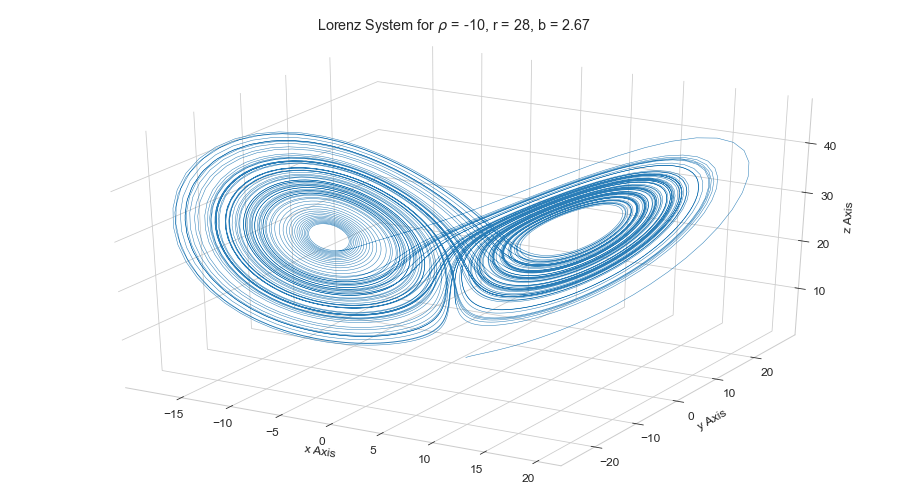

In [3]:
rho = -10
r = 28
b = 8 / 3

state0 = [1, 1, 1]
t = np.linspace(0, 100, 10_000)

LS = LorenzSystem(rho, r, b)
states = LS.solve(state0, t)
LS.plot()